In [1]:
%load_ext autoreload

In [2]:
import os
import json
import cv2
import glob
import swifter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle
#sns.set(style='darkgrid')
sns.set(style='darkgrid', context='notebook',font_scale=1.5)

In [3]:
%autoreload
import sys
sys.path.insert(0,'../')
from scripts.loader import *
import mytools as tl

# Datos

In [4]:
data_path = os.path.join('..', 'Datasets', 'Interiors')
resp_path = os.path.join(data_path, 'responses')
subj_path = os.path.join(data_path, 'human_scanpaths')
figs_path = os.path.join(os.getcwd(), 'figs')

In [5]:
data_path

'../Datasets/Interiors'

In [6]:
trials_data    = load_trials_properties(os.path.join(subj_path,'..', 'trials_properties.json'))
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
responses_data = tl.get_responses_features(subjs_response)
#responses_data = responses_data[responses_data.response_x <= 1024]
responses_data.head()

,subj,img,max_fixations,scanpath_length,target_found,target_found_response,response_size,distance_to_target,distance_to_last_fix,delta_time_response,response_x,response_y,target_bbox_x,target_bbox_y,response_target_relative_x,response_target_relative_y
0,41,grayscale_11_opensource.jpg,13,10,False,False,29,266.810794,213.164661,49.599536,486.0,447.0,228,559,-258.0,112.0
1,41,grayscale_18_housebeautiful.jpg,9,10,False,False,47,329.200547,411.615026,9.666707,520.0,538.0,797,400,277.0,-138.0
2,41,grayscale_100_oliva.jpg,5,3,True,False,19,202.054448,204.544005,5.633140,714.0,218.0,713,381,-1.0,163.0
3,41,grayscale_17_oliva.jpg,3,2,False,False,35,297.692795,208.923431,4.266648,433.0,316.0,186,490,-247.0,174.0
4,41,grayscale_16_housebeautiful.jpg,3,4,False,False,19,568.198029,223.650531,2.900187,762.0,442.0,158,421,-604.0,-21.0


# Performance acumulada

## A mano

<AxesSubplot:xlabel='max_fixations', ylabel='target_found'>

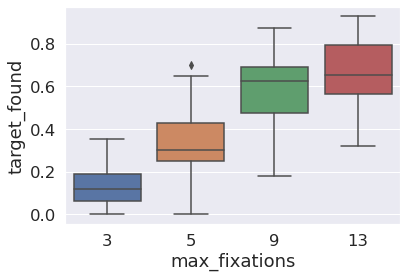

In [7]:
df=responses_data.groupby(['subj', 'max_fixations']).mean()['target_found']
sns.boxplot(data=df.reset_index(), x='max_fixations', y='target_found')

Using target found online


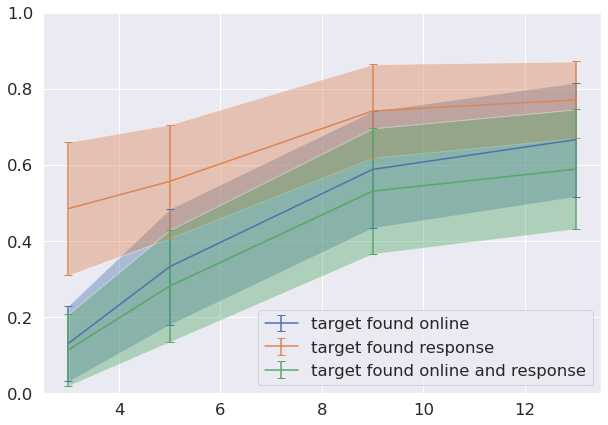

In [8]:
def cumulative_mean_performance_response(df, max_fix_key ='max_fixations', use_response=True):
    
    print('Using target found online')
    so = df.groupby(['subj', max_fix_key])['target_found'].sum()
    co = df.groupby(['subj', max_fix_key])['target_found'].count()
    perf_o = (so/co).groupby(['max_fixations']).agg(['mean', 'std'])
    
    if use_response:
        sr = df.groupby(['subj', max_fix_key])['target_found_response'].sum()
        cr = df.groupby(['subj', max_fix_key])['target_found_response'].count()
        perf_r = (sr/cr).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_r, lsuffix='_online', rsuffix='_response')
        df['target_found_online_response'] = df['target_found'] & df['target_found_response']
        so_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].sum()
        co_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].count()
        perf_o_r = (so_r/co_r).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_o_r)
        perf_o.rename(columns={'mean': 'mean_online_response', 'std': 'std_online_response'}, inplace=True)
        #perf_o.reset_index(inplace=True)
        
    return perf_o
 
aux  = cumulative_mean_performance_response(responses_data).reset_index()

_, ax = plt.subplots(1,1,figsize=(10,7))
ax.errorbar(aux['max_fixations'], aux['mean_online'], yerr = aux['std_online'], 
            label ='target found online', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_online']-aux['std_online'], 
                aux['mean_online']+aux['std_online'],
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_response'], yerr = aux['std_response'],
            label = 'target found response', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_response']-aux['std_response'], 
                aux['mean_response']+aux['std_response'], 
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_online_response'], yerr = aux['std_online_response'],
            label = 'target found online and response', capsize=4)
ax.fill_between(aux['max_fixations'],
                aux['mean_online_response']-aux['std_online_response'], 
                aux['mean_online_response']+aux['std_online_response'], alpha=0.4)

ax.set_ylim(0,1)
ax.legend()

plt.savefig(os.path.join(figs_path, f'lineplot_performance_responses.png'))

In [9]:
responses_data.scanpath_length.value_counts()

4     1433
3     1172
5     1017
6      783
2      482
8      467
7      464
9      421
10     313
12     228
13     213
11     179
14     141
Name: scanpath_length, dtype: int64

## Usando las funciones del repo

No handles with labels found to put in legend.


[Cumulative performance] Computing human mean for Interiors dataset


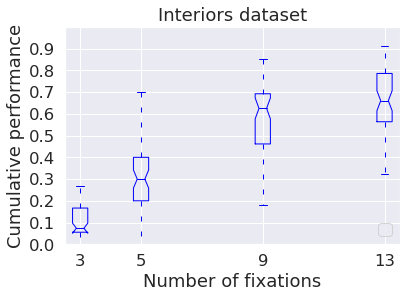

In [10]:
%autoreload
from Metrics.scripts.cumulative_performance import CumulativePerformance
perf = CumulativePerformance(dataset_name='Interiors', number_of_images=134, max_scanpath_length=15, compute=True)
#perf.compute_cumulative_performance(subjs_response[42])
perf.add_human_mean(humans_scanpaths_dir=os.path.join(resp_path, 'human_scanpaths'), humans_color='blue')
#perf.add_human_mean(humans_scanpaths_dir=subj_path, humans_color='blue')
perf.plot(save_path=figs_path)

# Performance: scanpath + respuesta

In [11]:
results_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions'

In [12]:
def load_results_responses(res_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions/'):
    import json
    #print(os.listdir(res_path))
    dout = []
    dout2 = []
    missing = []
    onefix = []
    for subj_file in sorted([file for file in os.listdir(res_path) if 'fixations' in file]):
        with open(os.path.join(res_path, subj_file)) as json_file:
            d = json.load(json_file)
            for img in d.keys():
                for metric in d[img].keys():
                    val   = list(d[img][metric].values())
                    n_fix = len(val)
                    avg_r = np.mean(val)
                    # 'mean_no_response'
                    avg_nr = np.mean(val[:-1])
                    # 'mean_last_two'
                    avg_last_fix = np.mean(val[-3:-1])
                    if len(list(val))==0:
                        missing.append((subj_file, img, metric, 'length 0'))
                    elif np.nan in val:
                        missing.append((subj_file, img, metric, 'nans'))
                    elif len(val) ==1:
                        onefix.append((subj_file, img, metric, 'one fix'))    
                    dout.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'response':val[-1], 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                    for i,f in enumerate(val):
                        if i==len(val)-1:
                            nsacc = 'response'
                        elif i==len(val)-2:
                            nsacc = 'last'
                        else:
                            nsacc = i
                        dout2.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'val':val[i], 'nsacc': nsacc, 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                        
                        
    return pd.DataFrame(dout),pd.DataFrame(dout2), missing, onefix

df_out, df_out_all, miss, onefix = load_results_responses(res_path=results_path)
print(f'Cantidad de datos con errores: {len(miss)}')
print(f'Cantidad de datos con una fijación: {len(onefix)}')

Cantidad de datos con errores: 0
Cantidad de datos con una fijación: 0


In [13]:
# No hay errores pero sin embargo hay NaNs
print(f'Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: {df_out.mean_no_response.isna().sum()}')

Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: 0


In [14]:
df_out.shape, df_out_all.shape, len(onefix)

((29252, 8), (173384, 9), 0)

In [15]:
df_out_all.columns

Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
       'mean_no_response', 'mean_last_two'],
      dtype='object')

## Crear columna distancia a la fijación del último mapa


### Sanity check

In [17]:
# Comprobamos si nfix (que seria mas un nsac) que se lee del json coincide con la cantidad de csv guardados por sacada
aux1 = df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(len)
aux2 = (aux1 == df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(lambda x: x.iloc[0,:].n_fix))
aux2.sum() == aux2.shape[0]

True

In [18]:
# Comprobar si la cantidad de mapas coincide con la cantidad de sacadas del sujeto seguido en cada caso


### Mapas de sacadas y distancia al modelo

In [16]:
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
responses_data = tl.get_responses_features(subjs_response).set_index(['subj', 'img'])
responses_data.head()

max_fixations  scanpath_length  \
subj img                                                               
41   grayscale_11_opensource.jpg                 13               10   
     grayscale_18_housebeautiful.jpg              9               10   
     grayscale_100_oliva.jpg                      5                3   
     grayscale_17_oliva.jpg                       3                2   
     grayscale_16_housebeautiful.jpg              3                4   

                                      target_found  target_found_response  \
subj img                                                                    
41   grayscale_11_opensource.jpg             False                  False   
     grayscale_18_housebeautiful.jpg         False                  False   
     grayscale_100_oliva.jpg                  True                  False   
     grayscale_17_oliva.jpg                  False                  False   
     grayscale_16_housebeautiful.jpg         False                  False   

                                      response_size  distance_to_target  \
subj img                                                                  
41   grayscale_11_opensource.jpg                 29          266.810794   
     grayscale_18_housebeautiful.jpg             47          329.200547   
     grayscale_100_oliva.jpg                     19          202.054448   
     grayscale_17_oliva.jpg                      35          297.692795   
     grayscale_16_housebeautiful.jpg             19          568.198029   

                                      distance_to_last_fix  \
subj img                                                     
41   grayscale_11_opensource.jpg                213.164661   
     grayscale_18_housebeautiful.jpg            411.615026   
     grayscale_100_oliva.jpg                    204.544005   
     grayscale_17_oliva.jpg                     208.923431   
     grayscale_16_housebeautiful.jpg            223.650531   

                                      delta_time_response  response_x  \
subj img                                                                
41   grayscale_11_opensource.jpg                49.599536       486.0   
     grayscale_18_housebeautiful.jpg             9.666707       520.0   
     grayscale_100_oliva.jpg                     5.633140       714.0   
     grayscale_17_oliva.jpg                      4.266648       433.0   
     grayscale_16_housebeautiful.jpg             2.900187       762.0   

                                      response_y  target_bbox_x  \
subj img                                                          
41   grayscale_11_opensource.jpg           447.0            228   
     grayscale_18_housebeautiful.jpg       538.0            797   
     grayscale_100_oliva.jpg               218.0            713   
     grayscale_17_oliva.jpg                316.0            186   
     grayscale_16_housebeautiful.jpg       442.0            158   

                                      target_bbox_y  \
subj img                                              
41   grayscale_11_opensource.jpg                559   
     grayscale_18_housebeautiful.jpg            400   
     grayscale_100_oliva.jpg                    381   
     grayscale_17_oliva.jpg                     490   
     grayscale_16_housebeautiful.jpg            421   

                                      response_target_relative_x  \
subj img                                                           
41   grayscale_11_opensource.jpg                          -258.0   
     grayscale_18_housebeautiful.jpg                       277.0   
     grayscale_100_oliva.jpg                                -1.0   
     grayscale_17_oliva.jpg                               -247.0   
     grayscale_16_housebeautiful.jpg                      -604.0   

                                      response_target_relative_y  
subj img                                                          
41   grayscale_11_opensource.jpg                     

In [17]:
df_out_all.head(20)

,subj,img,metric,n_fix,val,nsacc,mean_response,mean_no_response,mean_last_two
0,1,grayscale_1_housebeautiful.jpg,AUC,8,0.797526,0,0.888021,0.872675,0.966146
1,1,grayscale_1_housebeautiful.jpg,AUC,8,0.956380,1,0.888021,0.872675,0.966146
2,1,grayscale_1_housebeautiful.jpg,AUC,8,0.854818,2,0.888021,0.872675,0.966146
3,1,grayscale_1_housebeautiful.jpg,AUC,8,0.707682,3,0.888021,0.872675,0.966146
4,1,grayscale_1_housebeautiful.jpg,AUC,8,0.860026,4,0.888021,0.872675,0.966146
5,1,grayscale_1_housebeautiful.jpg,AUC,8,0.940755,5,0.888021,0.872675,0.966146
6,1,grayscale_1_housebeautiful.jpg,AUC,8,0.991536,last,0.888021,0.872675,0.966146
7,1,grayscale_1_housebeautiful.jpg,AUC,8,0.995443,response,0.888021,0.872675,0.966146
8,1,grayscale_1_housebeautiful.jpg,NSS,8,0.104728,0,1.340039,1.481253,3.569346
9,1,grayscale_1_housebeautiful.jpg,NSS,8,2.001721,1,1.340039,1.481253,3.569346


In [18]:
from visualsearch.grid import Grid

def map_fix_to_grid_(fix, img_w, img_h, grid):
    new_size = grid.size()
    fix_mapped_x = tl.rescale_coordinate(fix[1], img_w, new_size[1])
    fix_mapped_y = tl.rescale_coordinate(fix[0], img_h, new_size[0])
    return np.array([fix_mapped_y,fix_mapped_x])

def get_fixation_maps_path_(subj, img, path):
    name = f'subject_{subj:02d}'
    p = os.path.join(path, name, 'probability_maps', img[:-4])
    fix_map_paths_ = sorted(os.listdir(p))
    return [os.path.join(p,fix_map_) for fix_map_ in fix_map_paths_]

def get_fixation_from_extended_(subj, img, path, nsacc=-1):
    name = f'subject_{subj:02d}'
    p = os.path.join(path, name, 'Subject_scanpaths.json')
    d = load_dict_from_json(p)
    fix_x = d[img]['X'][nsacc]
    fix_y = d[img]['Y'][nsacc]
    return np.array([fix_y, fix_x])

def get_standarized_fixation_val_(fix, map, mean, std):
    return (map[fix[0], fix[1]]-mean)/std

def load_fixation_maps(subj, img, path, disp_plot=False):
    maps = get_fixation_maps_path_(subj, img, path)
    fix_maps = [pd.read_csv(m).values for m in maps]
    #print(f'Total saccades: {len(fix_maps)}')
    if disp_plot:
        last_map = fix_maps[disp_plot]*255
        with sns.plotting_context("talk"):
            plt.imshow(last_map)
    return np.array(fix_maps)

def get_model_next_fix_(maps, nsacc):
    return np.array(np.unravel_index(np.argmax(maps[nsacc,], axis=None), maps[nsacc,].shape))

def get_map_range_(maps, nsacc):
    return maps[nsacc].min(), maps[nsacc,].max()
    
def distance_between_fix_(subj, img, nsacc, path, img_w = 1024, img_h = 768):
    # TODO: Tengo que agregarle que cuando nsacc sea -2 compare no contra la respuesta sino contra la ultima fijacion
    if nsacc == 'last': 
        nsacc = -2
    elif nsacc == 'response': 
        nsacc = -1
    else:
        return -1
    subject_fix = get_fixation_from_extended_(subj, img, path, nsacc) 
    # me traigo la fijacion del modelo
    maps      = load_fixation_maps(subj, img, path)
    model_fix = get_model_next_fix_(maps, nsacc)
    maps_mean, maps_std = maps.mean(axis=(1,2)), maps.std(axis=(1,2))
    nss_subj  = get_standarized_fixation_val_(subject_fix, maps[nsacc,:,:], maps_mean[nsacc], maps_std[nsacc])
    nss_model = get_standarized_fixation_val_(model_fix, maps[nsacc,:,:], maps_mean[nsacc], maps_std[nsacc])
    map_min, map_max = get_map_range_(maps, nsacc)
    return np.linalg.norm(model_fix-subject_fix), nss_subj, nss_model, map_min, map_max, maps_mean[nsacc], maps_std[nsacc]
    #return np.linalg.norm(model_fix-subject_fix), maps, subject_fix, model_fix
    
# para hacerlo mas rápido tendría que cagar todo de una e iterar sobre un gruopby (subj,img)


In [22]:
# Test function
#a = distance_between_fix_(15, 'grayscale_1_housebeautiful.jpg', 'last', results_path)
#a[4]

#get_fixation_from_extended_(3, 'grayscale_1_housebeautiful.jpg', results_path, -2)
#load_fixation_maps(3, 'grayscale_1_housebeautiful.jpg', results_path)
#get_model_next_fix_(maps, -2)

#a, a_m, a_sf, a_mf = distance_between_fix_(15, 'grayscale_1_housebeautiful.jpg', 'last', results_path)
#plt.imshow(a_m[-1]), a_sf, a_m[-1].shape, a_m[-1][19,31], a_m[-1, a_sf[0], a_sf[1]]

In [19]:
# pruebo con pandas apply
df = df_out_all[df_out_all.nsacc.isin(['last','response'])].copy()
subj_model_distance_aux = df.apply(lambda x: distance_between_fix_(x.subj, x.img, x.nsacc, results_path), axis=1)

In [20]:
aux = pd.DataFrame(subj_model_distance_aux.tolist(), index=df.index, columns=['subj_model_distance', 'nss_subj', 'nss_model'
                                                                                ,'map_min', 'map_max', 'map_mean', 'map_std'])
df_new = pd.concat([df,aux],axis=1)
df = df_new.copy()

In [ ]:
# pruebo con swifter - 12 min. aprox.
#df = df_out_all[df_out_all.nsacc.isin(['last','response'])].copy()
#df['subj_model_distance']=df.swifter.apply(lambda x: distance_between_fix_(x.subj, x.img, x.nsacc, results_path), axis=1)

In [21]:
df.tail(10)

,subj,img,metric,n_fix,val,nsacc,mean_response,mean_no_response,mean_last_two,subj_model_distance,nss_subj,nss_model,map_min,map_max,map_mean,map_std
173374,57,grayscale_98_oliva.jpg,LL,11,-0.006881,last,0.526821,0.548262,-0.024519,19.104973,0.286813,5.160871,0.032239,0.048479,0.036495,0.002322
173375,57,grayscale_98_oliva.jpg,LL,11,0.312412,response,0.526821,0.548262,-0.024519,18.027756,0.255894,5.156511,0.041432,0.057124,0.046301,0.002099
173376,57,grayscale_100_oliva.jpg,AUC,2,0.990234,last,0.988281,0.990234,0.990234,2.236068,4.376917,5.905251,0.018018,0.064290,0.022714,0.007040
173377,57,grayscale_100_oliva.jpg,AUC,2,0.986328,response,0.988281,0.990234,0.990234,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460
173378,57,grayscale_100_oliva.jpg,NSS,2,4.376917,last,4.736651,4.376917,4.376917,2.236068,4.376917,5.905251,0.018018,0.064290,0.022714,0.007040
173379,57,grayscale_100_oliva.jpg,NSS,2,5.096384,response,4.736651,4.376917,4.376917,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460
173380,57,grayscale_100_oliva.jpg,IG,2,1.617139,last,0.694803,1.617139,1.617139,2.236068,4.376917,5.905251,0.018018,0.064290,0.022714,0.007040
173381,57,grayscale_100_oliva.jpg,IG,2,-0.227532,response,0.694803,1.617139,1.617139,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460
173382,57,grayscale_100_oliva.jpg,LL,2,1.236733,last,0.767166,1.236733,1.236733,2.236068,4.376917,5.905251,0.018018,0.064290,0.022714,0.007040
173383,57,grayscale_100_oliva.jpg,LL,2,0.297598,response,0.767166,1.236733,1.236733,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460


In [22]:
df[(df.nsacc=='response')].tail()

,subj,img,metric,n_fix,val,nsacc,mean_response,mean_no_response,mean_last_two,subj_model_distance,nss_subj,nss_model,map_min,map_max,map_mean,map_std
173375,57,grayscale_98_oliva.jpg,LL,11,0.312412,response,0.526821,0.548262,-0.024519,18.027756,0.255894,5.156511,0.041432,0.057124,0.046301,0.002099
173377,57,grayscale_100_oliva.jpg,AUC,2,0.986328,response,0.988281,0.990234,0.990234,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460
173379,57,grayscale_100_oliva.jpg,NSS,2,5.096384,response,4.736651,4.376917,4.376917,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460
173381,57,grayscale_100_oliva.jpg,IG,2,-0.227532,response,0.694803,1.617139,1.617139,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460
173383,57,grayscale_100_oliva.jpg,LL,2,0.297598,response,0.767166,1.236733,1.236733,2.000000,5.096384,9.308159,0.233052,0.361601,0.254931,0.011460


### Merge con el resto de la data

In [23]:
# merge con todos los datos - me quedan nans en las distancias hasta la proxima
print(df.shape, responses_data.shape)
df_all = df.merge(responses_data, on=['subj','img'])
print(df_all.shape, responses_data.shape)
print(df_all.columns)

(58504, 16) (7313, 14)
(58504, 30) (7313, 14)
Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
       'mean_no_response', 'mean_last_two', 'subj_model_distance', 'nss_subj',
       'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
       'max_fixations', 'scanpath_length', 'target_found',
       'target_found_response', 'response_size', 'distance_to_target',
       'distance_to_last_fix', 'delta_time_response', 'response_x',
       'response_y', 'target_bbox_x', 'target_bbox_y',
       'response_target_relative_x', 'response_target_relative_y'],
      dtype='object')


In [24]:
cols = ['subj', 'img', 'metric', 'nsacc','subj_model_distance',  'nss_subj',
       'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
       'max_fixations', 'scanpath_length', 'target_found',
       'target_found_response', 'response_size', 'distance_to_target',
       'distance_to_last_fix', 'delta_time_response', 'response_x',
       'response_y']
df_all = df_all[cols].merge(df_out_all, on=['subj','img','metric', 'nsacc'], how='outer')
df_all.head(10)

,subj,img,metric,nsacc,subj_model_distance,nss_subj,nss_model,map_min,map_max,map_mean,...,distance_to_target,distance_to_last_fix,delta_time_response,response_x,response_y,n_fix,val,mean_response,mean_no_response,mean_last_two
0,1,grayscale_1_housebeautiful.jpg,AUC,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,...,21.540659,78.365809,0.466865,186.0,199.0,8,0.991536,0.888021,0.872675,0.966146
1,1,grayscale_1_housebeautiful.jpg,AUC,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,...,21.540659,78.365809,0.466865,186.0,199.0,8,0.995443,0.888021,0.872675,0.966146
2,1,grayscale_1_housebeautiful.jpg,NSS,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,...,21.540659,78.365809,0.466865,186.0,199.0,8,5.124688,1.340039,1.481253,3.569346
3,1,grayscale_1_housebeautiful.jpg,NSS,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,...,21.540659,78.365809,0.466865,186.0,199.0,8,0.351543,1.340039,1.481253,3.569346
4,1,grayscale_1_housebeautiful.jpg,IG,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,...,21.540659,78.365809,0.466865,186.0,199.0,8,1.183885,-0.050026,-0.339807,1.063493
5,1,grayscale_1_housebeautiful.jpg,IG,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,...,21.540659,78.365809,0.466865,186.0,199.0,8,1.978444,-0.050026,-0.339807,1.063493
6,1,grayscale_1_housebeautiful.jpg,LL,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,...,21.540659,78.365809,0.466865,186.0,199.0,8,0.063124,0.251722,0.287270,0.238036
7,1,grayscale_1_housebeautiful.jpg,LL,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,...,21.540659,78.365809,0.466865,186.0,199.0,8,0.002880,0.251722,0.287270,0.238036
8,1,grayscale_1_kitchen.jpg,AUC,last,16.124515,0.811794,6.146613,0.010120,0.053109,0.014385,...,10.630146,59.573148,0.666899,883.0,313.0,6,0.867839,0.774306,0.729297,0.749349
9,1,grayscale_1_kitchen.jpg,AUC,response,0.000000,9.522324,9.522324,0.095728,0.158703,0.105442,...,10.630146,59.573148,0.666899,883.0,313.0,6,0.999349,0.774306,0.729297,0.749349


In [25]:
df_all.shape

(173384, 26)

In [26]:
# la cantidad de nans tendria que coincidir con df_out_all.shape - df.shape (lo cual lo hace)
df_all.isna().sum(axis=0)

subj                          0
img                           0
metric                        0
nsacc                         0
subj_model_distance      114880
nss_subj                 114880
nss_model                114880
map_min                  114880
map_max                  114880
map_mean                 114880
map_std                  114880
max_fixations            114880
scanpath_length          114880
target_found             114880
target_found_response    114880
response_size            114880
distance_to_target       114880
distance_to_last_fix     114880
delta_time_response      114880
response_x               114880
response_y               114880
n_fix                         0
val                           0
mean_response                 0
mean_no_response              0
mean_last_two                 0
dtype: int64

In [27]:
def cat_trial(row):
    if row['target_found'] and row['target_found_response']:
        return 'TFO & TFR'
    elif ~row['target_found'] and row['target_found_response']:
        return '~TFO & TFR'
    elif row['target_found'] and ~row['target_found_response']:
        return 'TFO & ~TFR'
    elif ~row['target_found'] and ~row['target_found_response']:
        return '~TFO & ~TFR'
    else:
        return 'ERROR'

responses_data_auxiliar_col = []
for idx, row in df_all.iterrows():
    responses_data_auxiliar_col.append(cat_trial(row))
df_all['found_category'] = responses_data_auxiliar_col

In [28]:
df_all.shape, df_all.columns

((173384, 27),
 Index(['subj', 'img', 'metric', 'nsacc', 'subj_model_distance', 'nss_subj',
        'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
        'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
        'mean_last_two', 'found_category'],
       dtype='object'))

### Save and load

In [29]:
# por las dudas lo guardamos en cache para ahorrarnos los 15 min previos
df_all.to_csv('./cache/df_con_distancias_11-10.csv')
# df_all = pd.read_csv('./cache/df_con_distancias_11-10.csv', header=0, index_col=0)

# Comparación de rendimiento medio

Hasta aca tengo dos dataframes principales, uno agregado y uno sin agregar y con mas informacion:
- df_out: tiene la informacion agregada, rendimiento medio para el par (subj, img) con columnas `['metric', 'n_fix', 'response', 'mean_response',
       'mean_no_response', 'mean_last_two']`
- df_all: tiene la informacion desagregada, incluyendo la metrica de distancia euclidea () entre la proxima ubicacion para el modelo y para el sujeto, columnas 
       `['nsacc', 'subj_model_distance', 'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
        'mean_last_two', 'found_category']`

In [38]:
df_all.head(8).iloc[:,:12]

,subj,img,metric,nsacc,subj_model_distance,nss_subj,nss_model,map_min,map_max,map_mean,map_std,max_fixations
0,1,grayscale_1_housebeautiful.jpg,AUC,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,0.002669,9.0
1,1,grayscale_1_housebeautiful.jpg,AUC,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,0.002624,9.0
2,1,grayscale_1_housebeautiful.jpg,NSS,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,0.002669,9.0
3,1,grayscale_1_housebeautiful.jpg,NSS,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,0.002624,9.0
4,1,grayscale_1_housebeautiful.jpg,IG,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,0.002669,9.0
5,1,grayscale_1_housebeautiful.jpg,IG,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,0.002624,9.0
6,1,grayscale_1_housebeautiful.jpg,LL,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,0.002669,9.0
7,1,grayscale_1_housebeautiful.jpg,LL,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,0.002624,9.0


In [39]:
(7.814689 * 0.002669) + 0.305867

0.326724404941

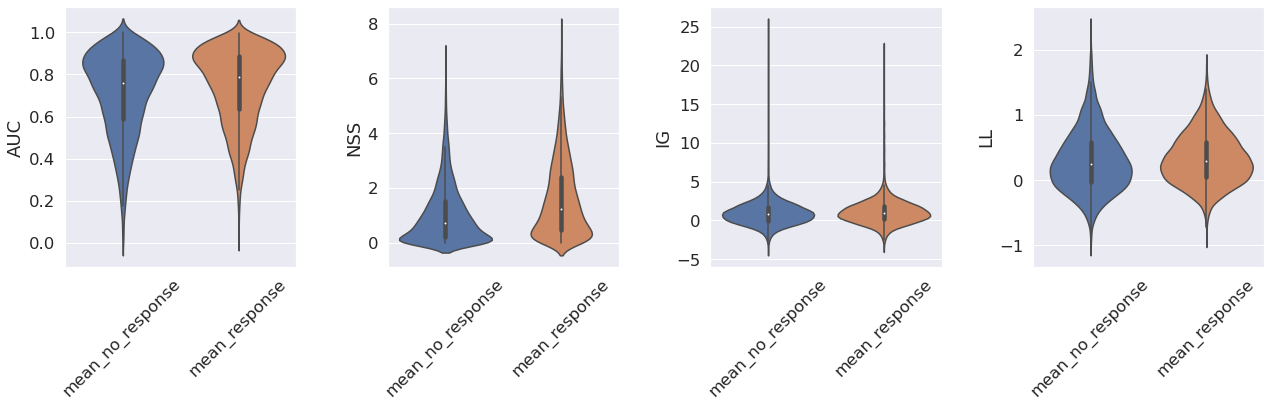

In [30]:
def compare_model_response_pred(df):
    return None

_, axs = plt.subplots(1,4, figsize=(18,6))
for ax, met in zip(axs.ravel(), df_out.metric.unique()):
    aux = df_out[df_out.metric==met][['mean_no_response', 'mean_response']]
    sns.violinplot(data=aux,ax=ax)
    ax.set_ylabel(met)
    ax.set_xticklabels(['mean_no_response','mean_response'], rotation=45) #ax.get_xticks()
plt.tight_layout()

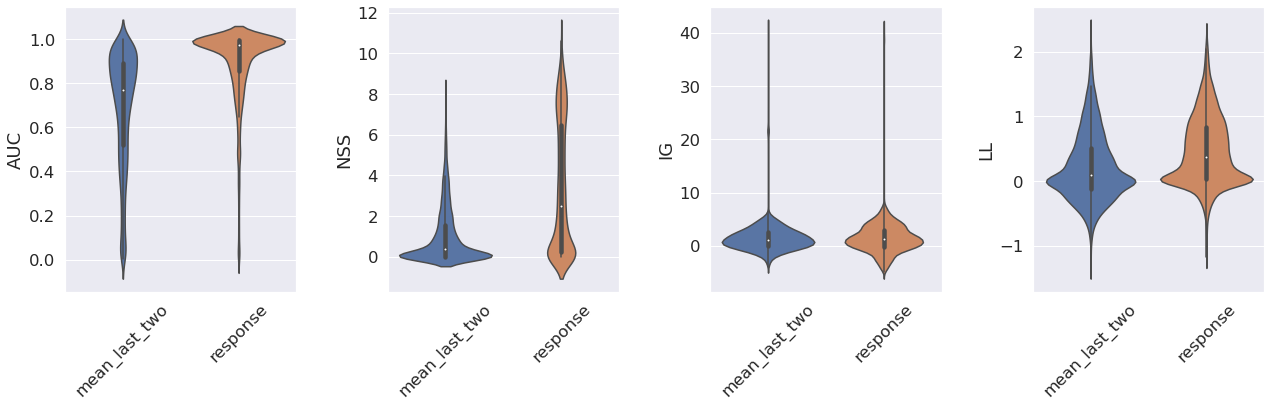

In [31]:
def compare_model_response_pred(df):
    return None

_, axs = plt.subplots(1,4, figsize=(18,6))
for ax, met in zip(axs.ravel(), df_out.metric.unique()):
    aux = df_out[df_out.metric==met][['mean_last_two','response']]
    sns.violinplot(data=aux,ax=ax,)
    ax.set_ylabel(met)
    ax.set_xticklabels(['mean_last_two','response'], rotation=45) #ax.get_xticks()
plt.tight_layout()

## Comparación por tipo de trial

/home/gastonb/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


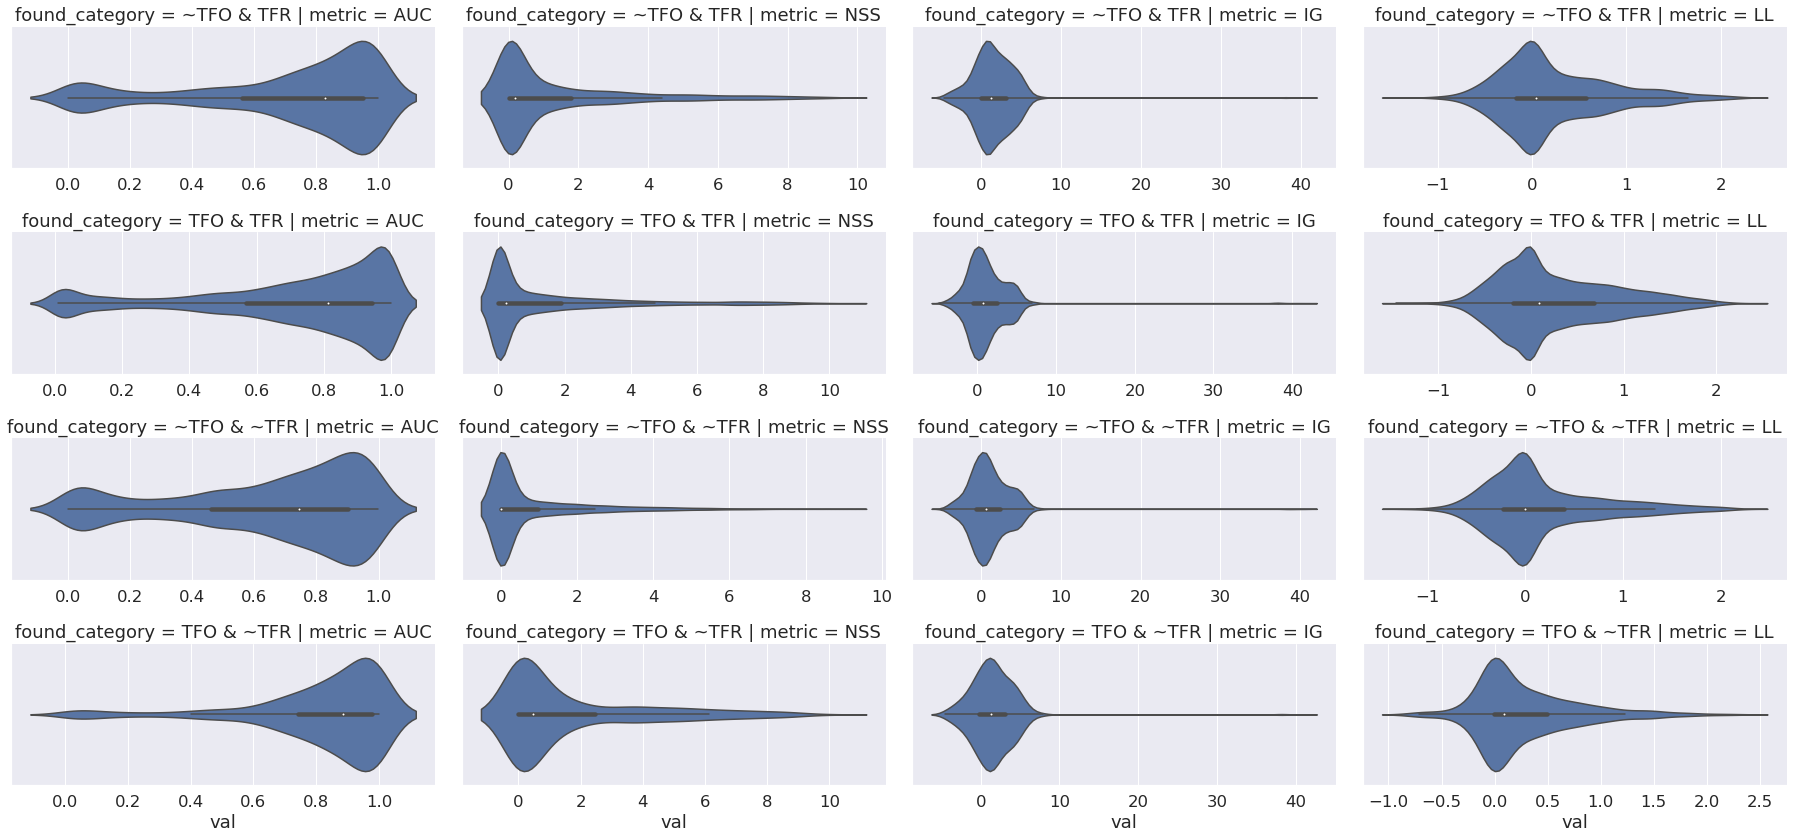

In [33]:
grid = sns.FacetGrid(df_all, col='metric', row='found_category',
                    palette="GnBu_d", height=3, aspect=2.1, sharex=False)

bins_hist = np.linspace(-4,4,30)
grid.map(sns.violinplot, 'val', stat='percent', alpha=0.8, common_norm=False);

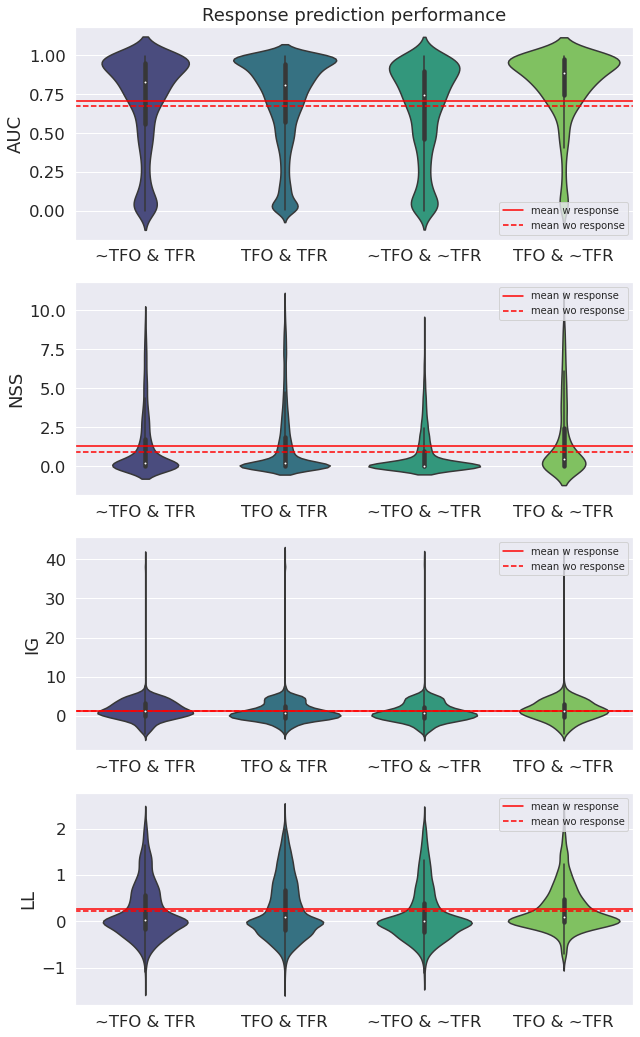

In [40]:
# AGREGAR EN CADA GRAFICO
# linea que sea la media del modelo para cada 

_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title('Response prediction performance');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all.query('metric==@met')
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category', data=aux, ax=ax, palette='viridis')
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean w response'))
    lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

In [41]:
df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))].head()

,subj,img,metric,nsacc,subj_model_distance,nss_subj,nss_model,map_min,map_max,map_mean,...,distance_to_last_fix,delta_time_response,response_x,response_y,n_fix,val,mean_response,mean_no_response,mean_last_two,found_category
6,1,grayscale_1_housebeautiful.jpg,LL,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,...,78.365809,0.466865,186.0,199.0,8,0.063124,0.251722,0.287270,0.238036,~TFO & TFR
7,1,grayscale_1_housebeautiful.jpg,LL,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,...,78.365809,0.466865,186.0,199.0,8,0.002880,0.251722,0.287270,0.238036,~TFO & TFR
14,1,grayscale_1_kitchen.jpg,LL,last,16.124515,0.811794,6.146613,0.010120,0.053109,0.014385,...,59.573148,0.666899,883.0,313.0,6,0.438859,0.258111,0.191759,0.123111,TFO & TFR
15,1,grayscale_1_kitchen.jpg,LL,response,0.000000,9.522324,9.522324,0.095728,0.158703,0.105442,...,59.573148,0.666899,883.0,313.0,6,0.589875,0.258111,0.191759,0.123111,TFO & TFR
22,1,grayscale_1_oliva.jpg,LL,last,13.000000,0.833679,4.588415,0.006270,0.041730,0.010588,...,38.296997,0.566944,153.0,627.0,5,0.617651,0.355577,0.124822,0.178579,TFO & TFR


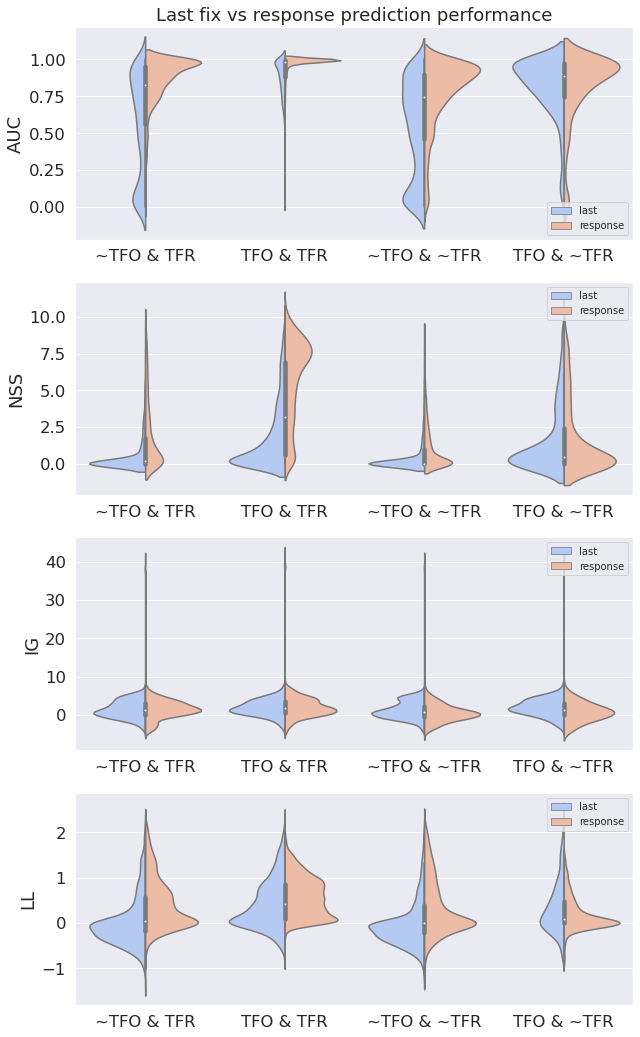

In [49]:
_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title('Last fix vs response prediction performance');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))]
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax, palette='coolwarm')
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    #lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean response'))
    #lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

## Distancia al modelo

<AxesSubplot:ylabel='Frequency'>

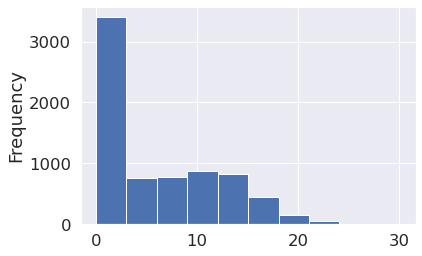

In [63]:
df[(df.nsacc=='response') & (df.metric=='LL')]['subj_model_distance'].plot(kind='hist')

In [64]:
aux = df_all[(df_all.metric=='LL') & (df_all.nsacc.isin(['response','last']))]
print(aux.shape)
aux.head()

(14626, 27)


,subj,img,metric,nsacc,subj_model_distance,nss_subj,nss_model,map_min,map_max,map_mean,...,distance_to_last_fix,delta_time_response,response_x,response_y,n_fix,val,mean_response,mean_no_response,mean_last_two,found_category
6,1,grayscale_1_housebeautiful.jpg,LL,last,1.000000,5.124688,7.814689,0.281429,0.326727,0.305867,...,78.365809,0.466865,186.0,199.0,8,0.063124,0.251722,0.287270,0.238036,~TFO & TFR
7,1,grayscale_1_housebeautiful.jpg,LL,response,1.414214,0.351543,0.433908,0.425230,0.462614,0.461476,...,78.365809,0.466865,186.0,199.0,8,0.002880,0.251722,0.287270,0.238036,~TFO & TFR
14,1,grayscale_1_kitchen.jpg,LL,last,16.124515,0.811794,6.146613,0.010120,0.053109,0.014385,...,59.573148,0.666899,883.0,313.0,6,0.438859,0.258111,0.191759,0.123111,TFO & TFR
15,1,grayscale_1_kitchen.jpg,LL,response,0.000000,9.522324,9.522324,0.095728,0.158703,0.105442,...,59.573148,0.666899,883.0,313.0,6,0.589875,0.258111,0.191759,0.123111,TFO & TFR
22,1,grayscale_1_oliva.jpg,LL,last,13.000000,0.833679,4.588415,0.006270,0.041730,0.010588,...,38.296997,0.566944,153.0,627.0,5,0.617651,0.355577,0.124822,0.178579,TFO & TFR


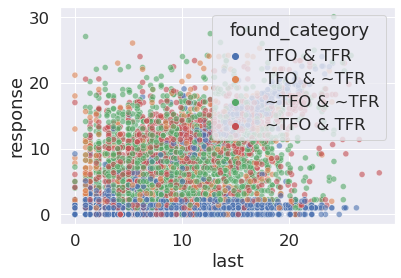

In [65]:
tabla_distancias = pd.pivot(aux[['subj', 'img','nsacc', 'subj_model_distance','found_category']], 
                            index=['subj', 'img','found_category'], columns='nsacc',values='subj_model_distance').reset_index()
sns.scatterplot(data=tabla_distancias, hue='found_category', x='last', y ='response', alpha=0.6)
plt.show()

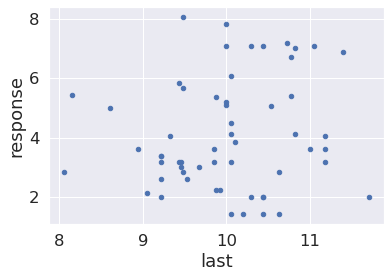

In [66]:
tabla_distancias.groupby(by='subj').median().plot(kind='scatter', x='last', y ='response',c='b')
plt.show()

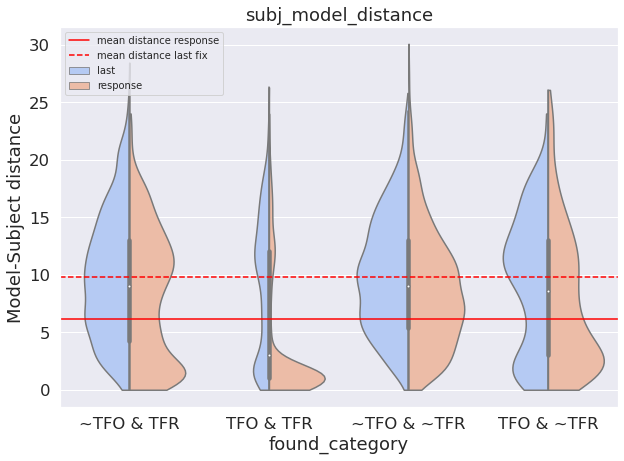

In [67]:
_, ax = plt.subplots(1,1, figsize=(10,7))
VAR = 'subj_model_distance'
ax.set_title(f'{VAR}');
aux = aux[~aux.mean_no_response.isna()]
sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax, cut=0, palette='coolwarm')
mean_dist_response = aux[VAR][aux.nsacc=='response'].mean() 
mean_dist_last     = aux[VAR][aux.nsacc=='last'].mean()
ax.axhline(mean_dist_response,color='red',ls='-', label='mean distance response')
ax.axhline(mean_dist_last,color='red',ls='--', label='mean distance last fix')
ax.legend(prop={'size': 10});
ax.set_ylabel('Model-Subject distance');

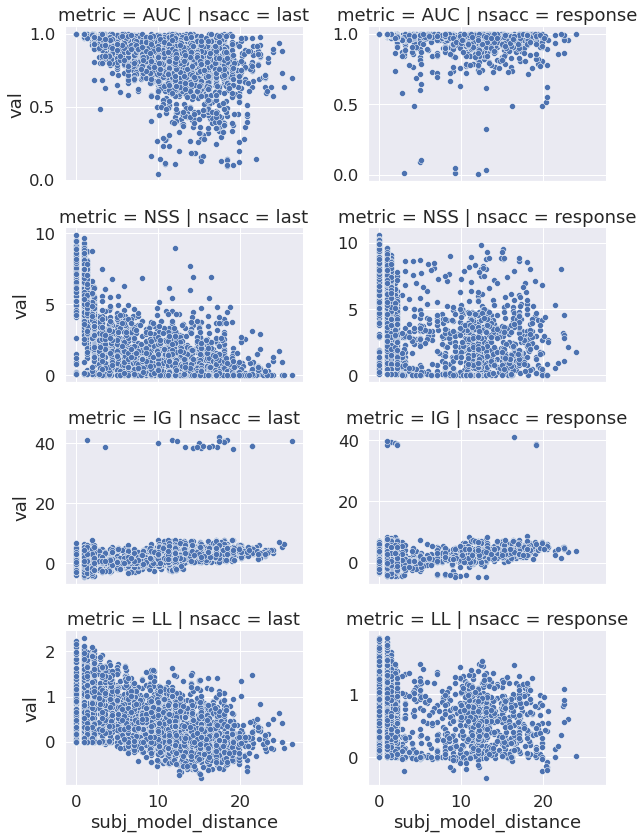

In [68]:
aux = df_all.query('found_category == "TFO & TFR"').query('nsacc == "last" or nsacc=="response"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, col='nsacc', row='metric', sharey=False, height=3, aspect=1.5)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

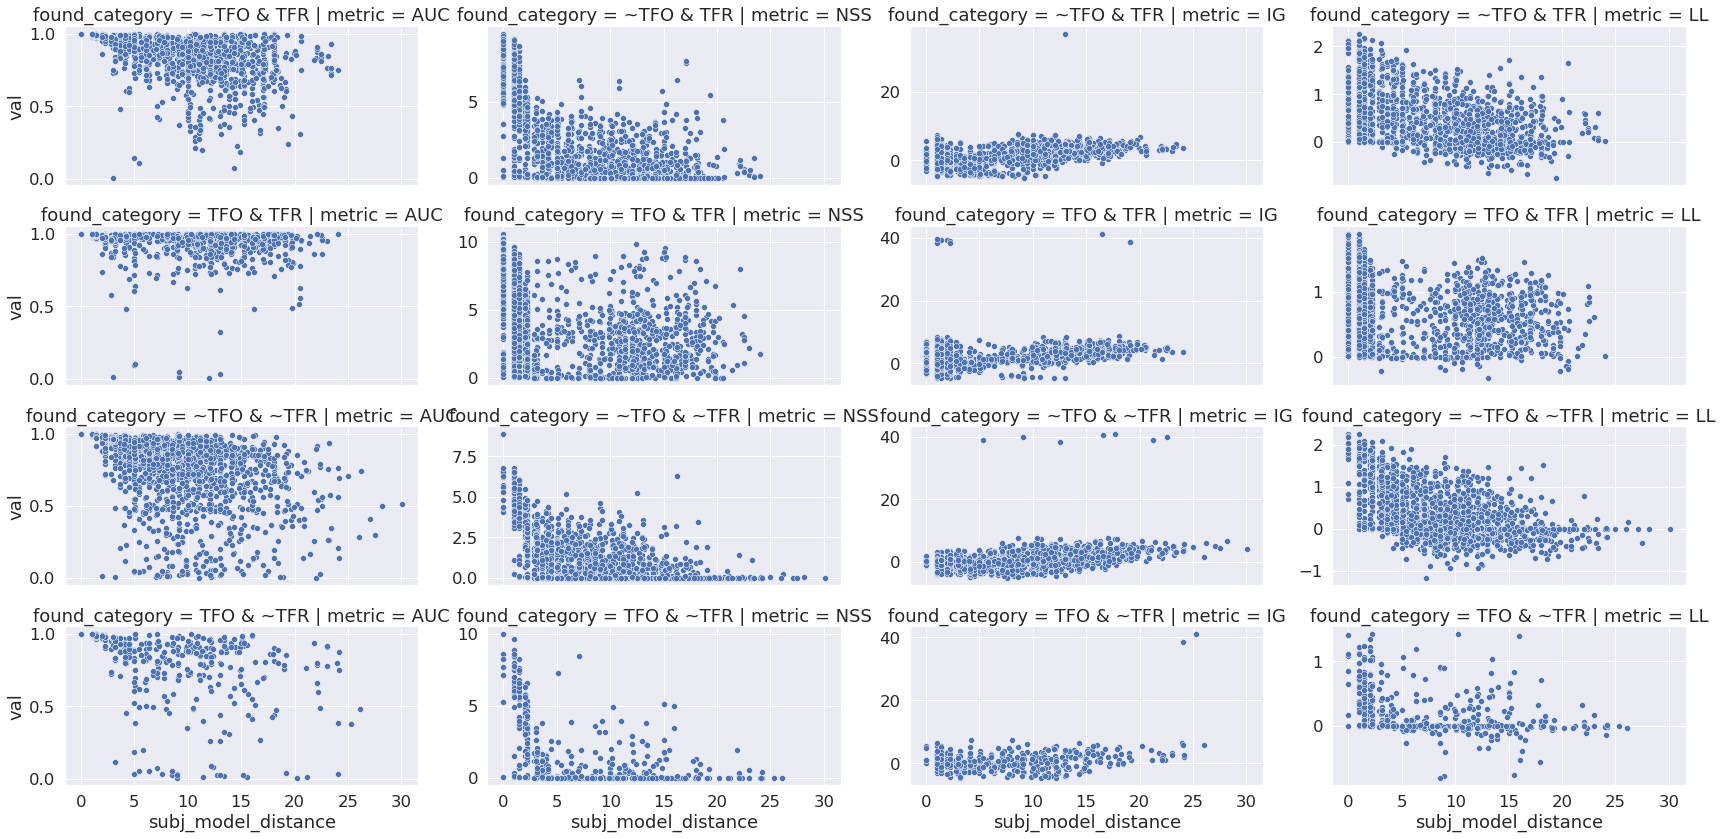

In [69]:
aux = df_all.query('nsacc=="response"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

Una cosa que podemos mirar es rendimiento por rango de fijaciones. Para cada rango de fijación tengo una distribución de scores (una distribución para cada métrica), la pregunta es si la distribución de las respuestas es distinta o no a la 

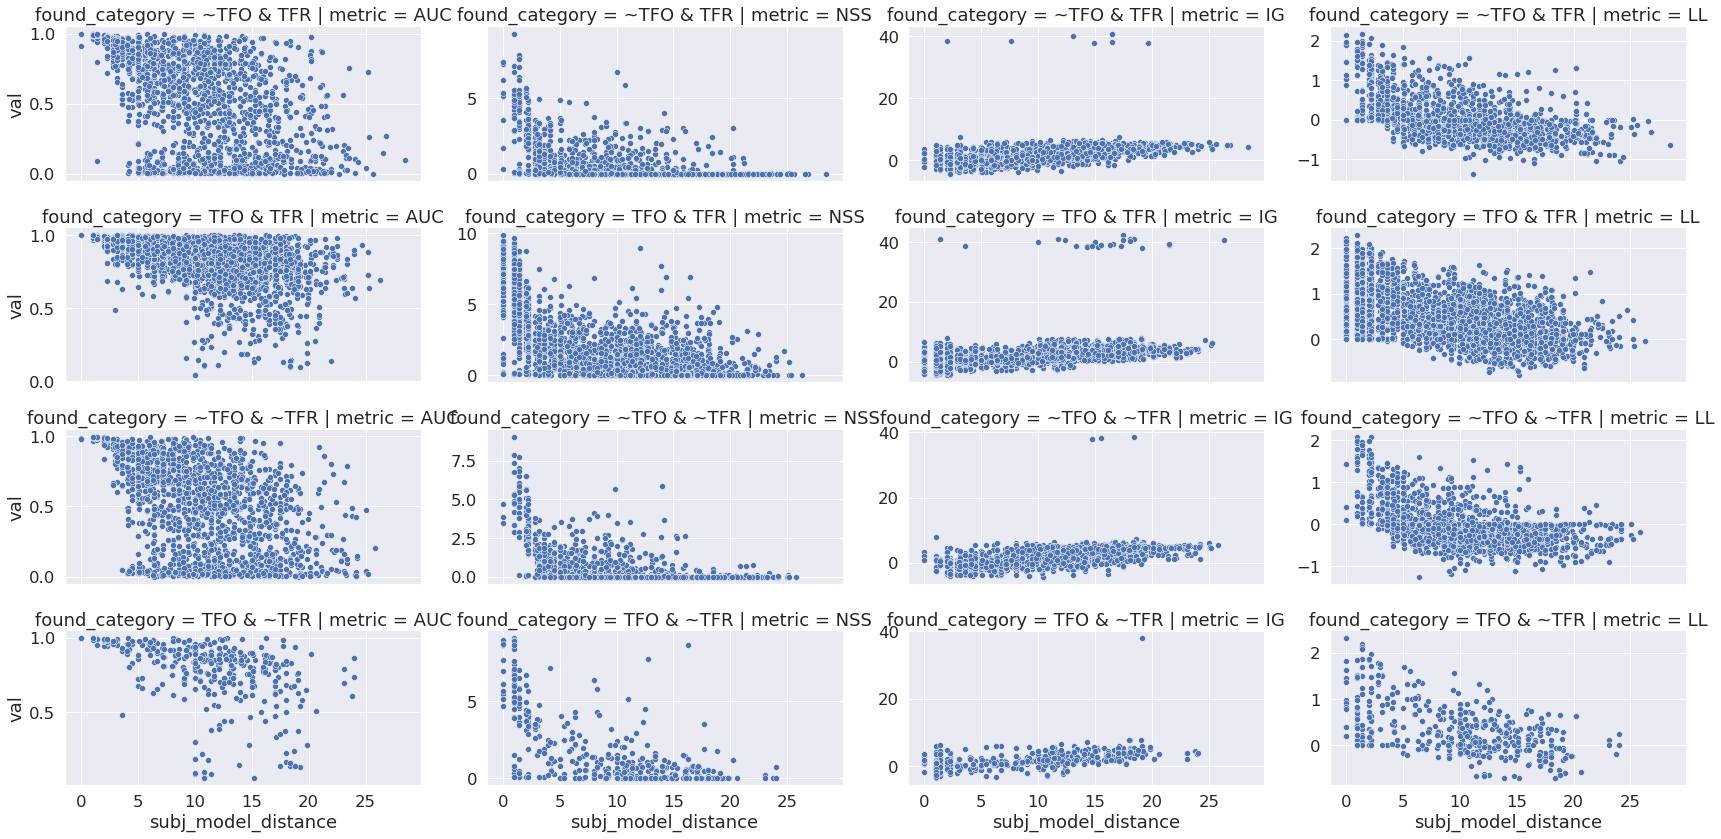

In [70]:
aux = df_all.query('nsacc=="last"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

### mirando respuesta, tamanio y nss

In [43]:
aux = df_all.query('nsacc=="response"')[['subj','img','nsacc','metric','val', 'nss_subj',
                'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std','subj_model_distance','found_category', 'response_size']]
aux['nss_diff'] = aux['nss_model'] - aux['nss_subj']
aux.columns

Index(['subj', 'img', 'nsacc', 'metric', 'val', 'nss_subj', 'nss_model',
       'map_min', 'map_max', 'map_mean', 'map_std', 'subj_model_distance',
       'found_category', 'response_size', 'nss_diff'],
      dtype='object')

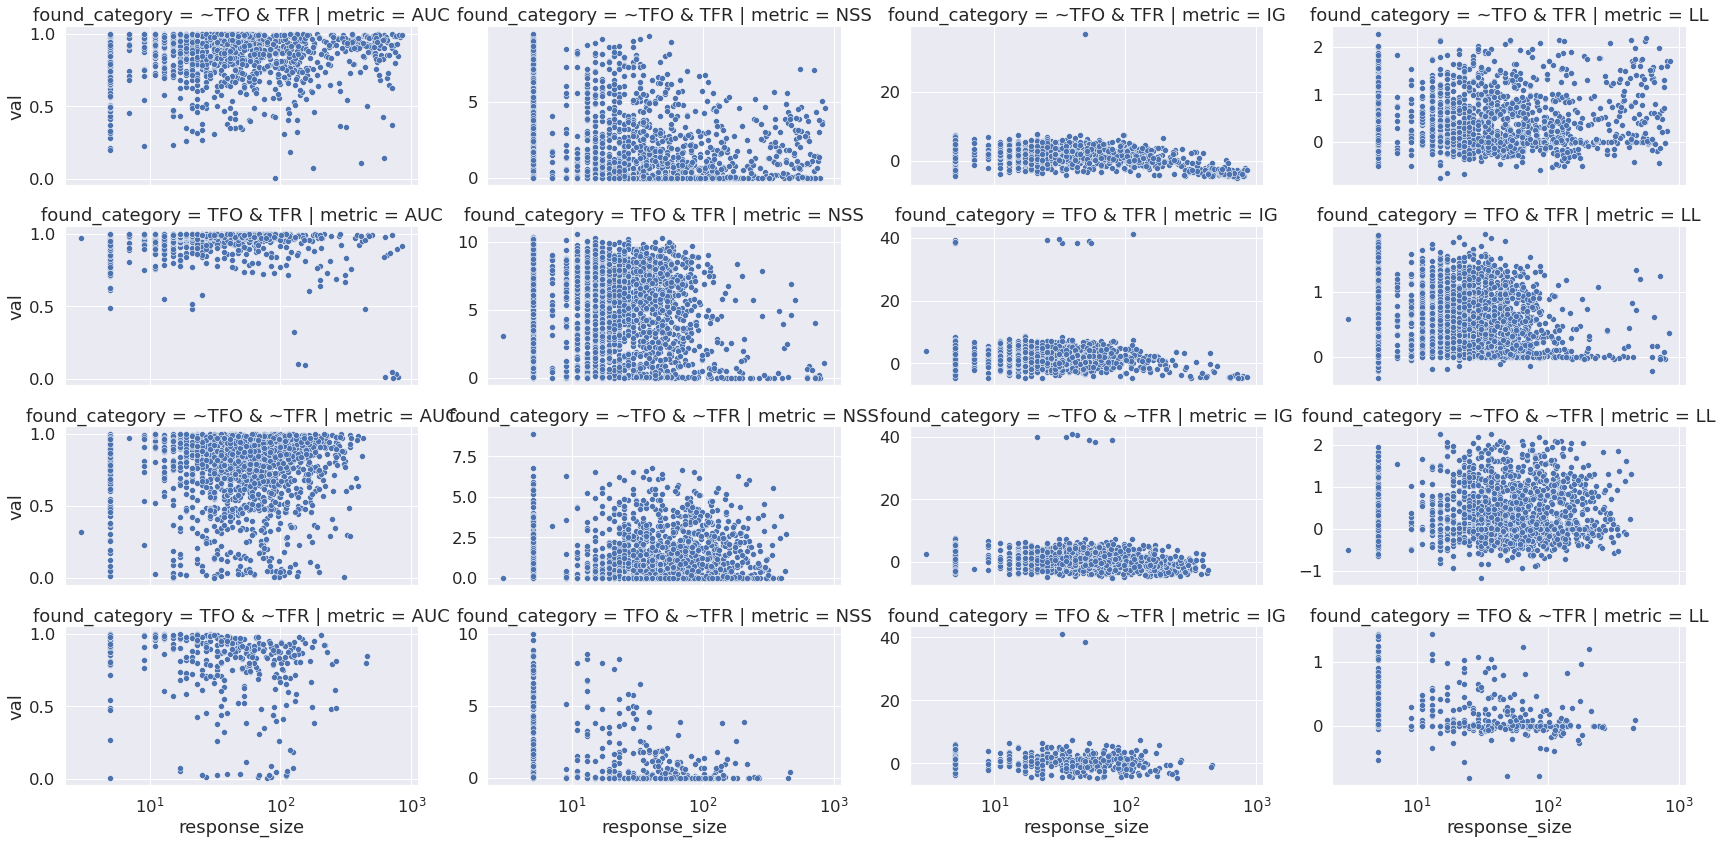

In [47]:
#
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'response_size','val').set(xscale = 'log')

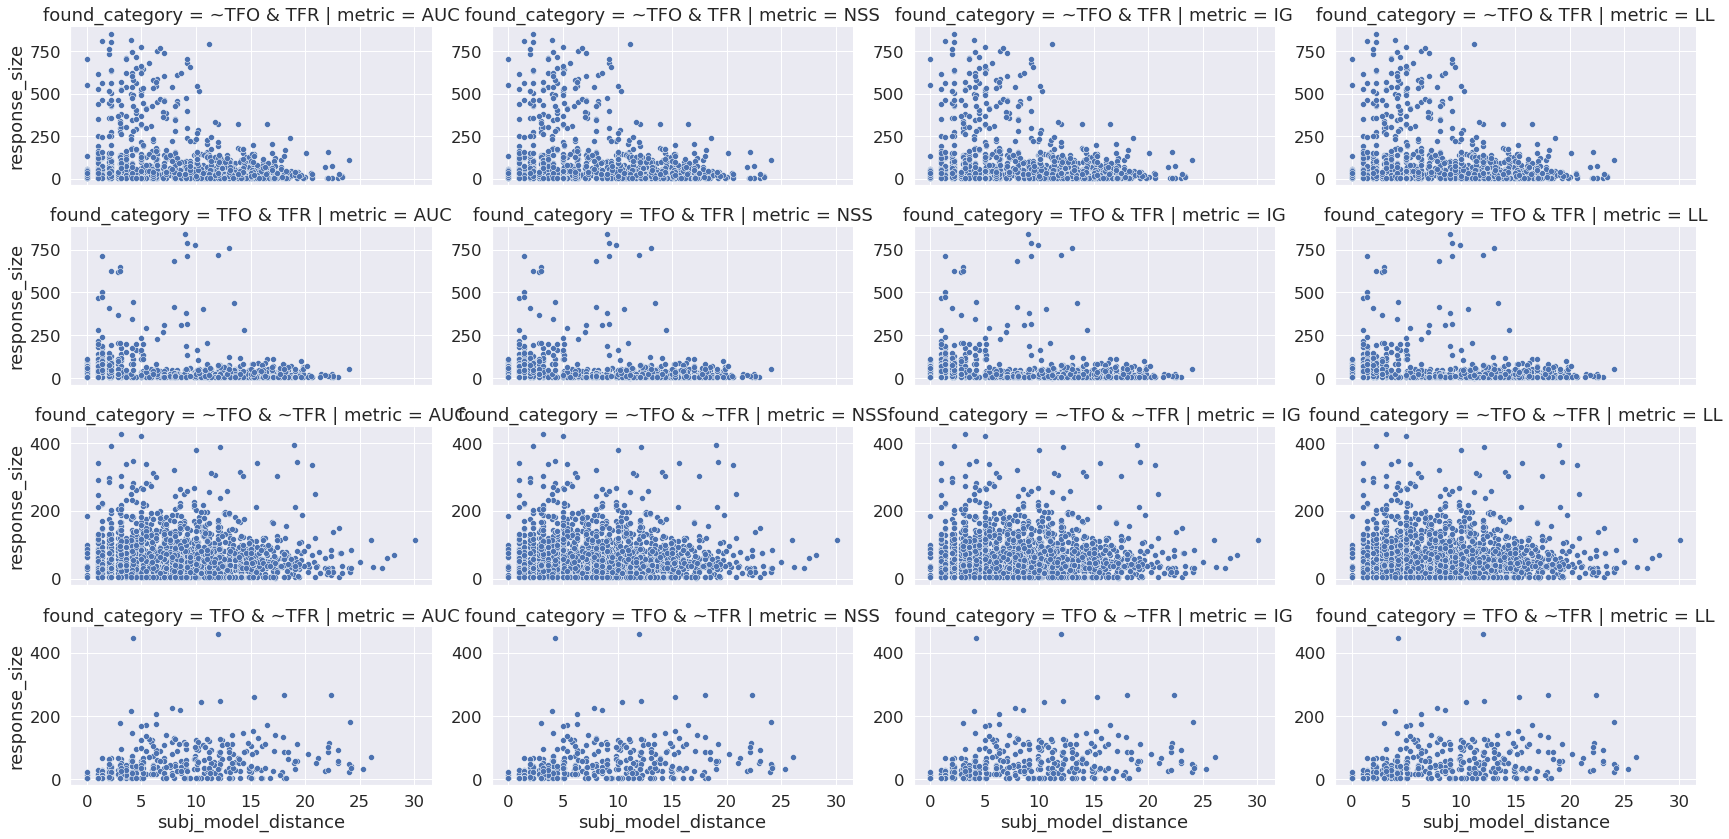

In [93]:
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot,'subj_model_distance','response_size')

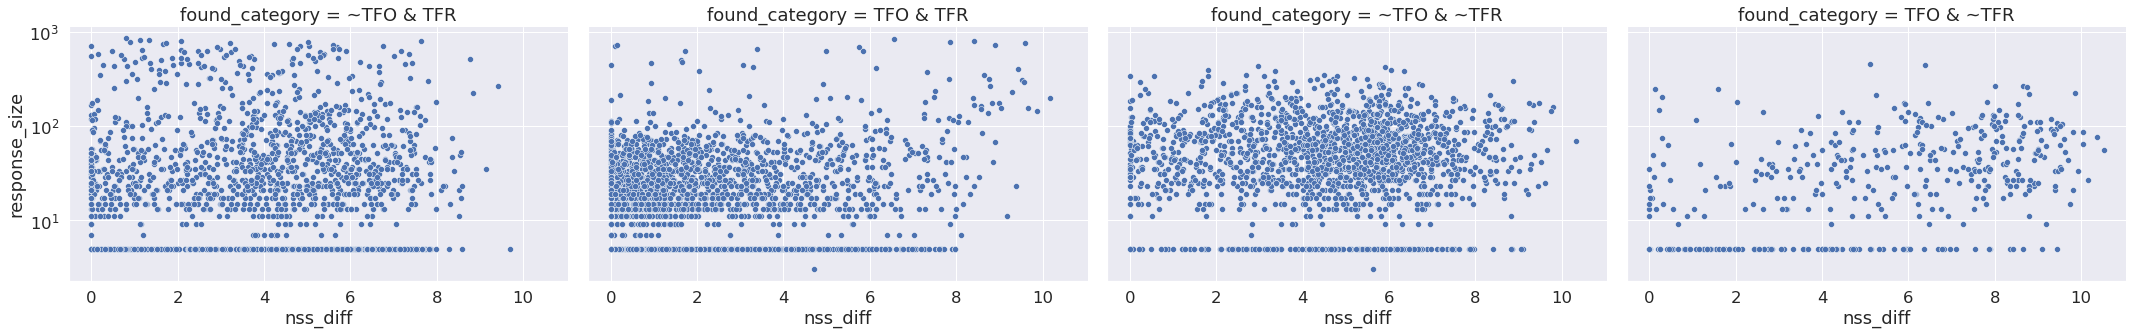

In [46]:
#
g = sns.FacetGrid(aux.query('metric=="NSS"'), col='found_category', height=5, aspect=1.5)
g.map(sns.scatterplot, 'nss_diff','response_size').set(yscale = 'log')

## Desagregando trials

Tengo que separar en nuevas dos categorias, vio el trial online y siguió

In [ ]:
df_all[df_all.nsacc.isin(['responses', 'last'])]

# Debug

In [ ]:
# Miremos algunos mapas
_ = load_fixation_maps(1, 'grayscale_1_housebeautiful.jpg',results_path, -3)